In [82]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import  torchvision.datasets
import torchvision.transforms as tf
from torchvision.datasets import DatasetFolder, ImageFolder
from torch.utils.data import DataLoader


# %matplotlib inline

# VGG19 Mystery Model 1

This is a Mystery Model, which is essentially a watered down version of VGG19. Due to the complexity of VGG19, watering it down ensures we reduce overfitting on small dataset

__note__ = Make sure to run the model before running the training set, in order to rest the model properly

## Training
Training and accuracy function (same as other VGG19 model)

In [83]:

def get_accuracy(model, data):
    '''
    @model: The model we are running training accuracy on.
    @data: A batch of images to check the accuracy
    @return: The probability of accuracy
    '''

    loader = torch.utils.data.DataLoader(data, batch_size=32)
    model.eval()
    correct = 0
    total = 0
    for imgs, labels in loader:
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train(model, train_data, batch_size=32, weight_decay=0.0,
          learning_rate=0.001, num_epochs=10, checkpoint_path=None,
          valid_data = None):
    '''
    @model: The MLP model we are training
    @batch_size: The batch size to use
    @weight_decay: The weight decay parameter for Adam optimizer
    @learning rate: The learning rate for the adam optimizer
    @nnum_epochs: The number of epochs to run
    '''

    # load the train data
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)



    # defining loss function and optimizer, using ADAM
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    # keeping track of training acc and val_acc
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            model.train()

            # forward pass and backward pass
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            # zero the gradient parameter
            optimizer.zero_grad()
            n += 1

        # calculating loss and accuracy
        loss = float(loss)/batch_size
        tacc = get_accuracy(model, train_data)

        if (valid_data!= None):
            vacc = get_accuracy(model, valid_data)
            print("Iter %d; Loss %f; Train Acc %.3f; Val Acc %.3f" % (n, loss, tacc, vacc))
            val_acc.append(vacc)
        else:
            print("Iter %d; Loss %f; Train Acc %.3f;" % (n, loss, tacc))

        iters.append(n)
        losses.append(loss)
        train_acc.append(tacc)

        # creating checkpoint for saving the model
        if (checkpoint_path is not None) and epoch % 10 == 0:
            torch.save(model.state_dict(), checkpoint_path.format(epoch))


    # plotting
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")

    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve")
    plt.plot(iters, train_acc, label="Train")
    if (valid_data!=None):
        plt.plot(iters, val_acc, label="Valid")

    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    PATH = './cifar_net.pth'+ model.name
    torch.save(model.state_dict(), PATH)

    print("Final Training Accuracy: {}".format(train_acc[-1]))


In [84]:
# function to show an image (taken from TUT09)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.ion()
    plt.show()

def dataPreparation(path, batchsize, imagesize, pathTest, validTest = None):
    transform = tf.Compose([tf.Resize((imagesize,imagesize)),
                            tf.RandomHorizontalFlip(),
                            tf.ToTensor(),
                            tf.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
    trainingdata= ImageFolder(root=path, transform=transform)
    testdata= ImageFolder(root=pathTest, transform=transform)
    trainloader = DataLoader(dataset=trainingdata, batch_size= batchsize, shuffle=True)
    classes_ = trainingdata.classes

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = next(dataiter)

    # show images
    imshow(torchvision.utils.make_grid(images))

    validdata = None
    if (validTest != None):
        validdata= ImageFolder(root=validTest, transform=transform)

    # print labels
    print(' '.join('%5s' % classes_[labels[j]] for j in range(4)))

    return trainingdata, testdata, validdata

In [98]:
class VGG19MM(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG19MM, self).__init__()
        self.name = "VGG19MM"
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=4,
                               kernel_size=3,
                               padding=1)
        self.bn1 = nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(in_channels=4,
                               out_channels=8,
                               kernel_size=3,
                               padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(in_channels=8,
                               out_channels=16,
                               kernel_size=3,
                               padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(in_channels=16,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128, 100)
        self.fc2 = nn.Linear(100, num_classes)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.bn3(x)
        x = self.pool(torch.relu(self.conv4(x)))
        x = self.bn4(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Running VGG19 mystery model on Tumor dataset

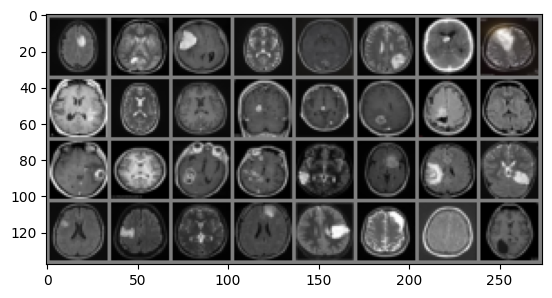

  yes   yes   yes    no


Dataset ImageFolder
    Number of datapoints: 202
    Root location: ./data/tumor/train/
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [93]:
traindata, testdata, validdata = dataPreparation(path="./data/tumor/train/", batchsize=32,imagesize=32, pathTest="./data/tumor/test/")
traindata

In [94]:
VGG19MM = VGG19MM(2)

Iter 7; Loss 0.015263; Train Acc 0.386; Val Acc 0.380
Iter 14; Loss 0.010757; Train Acc 0.386; Val Acc 0.380
Iter 21; Loss 0.011827; Train Acc 0.401; Val Acc 0.400
Iter 28; Loss 0.007117; Train Acc 0.589; Val Acc 0.620
Iter 35; Loss 0.009143; Train Acc 0.837; Val Acc 0.640
Iter 42; Loss 0.008370; Train Acc 0.926; Val Acc 0.820
Iter 49; Loss 0.005553; Train Acc 0.936; Val Acc 0.800
Iter 56; Loss 0.004511; Train Acc 0.960; Val Acc 0.840
Iter 63; Loss 0.003271; Train Acc 0.975; Val Acc 0.840
Iter 70; Loss 0.005162; Train Acc 0.975; Val Acc 0.860
Iter 77; Loss 0.000822; Train Acc 0.985; Val Acc 0.900
Iter 84; Loss 0.003037; Train Acc 1.000; Val Acc 0.940
Iter 91; Loss 0.000939; Train Acc 1.000; Val Acc 0.880
Iter 98; Loss 0.000259; Train Acc 1.000; Val Acc 0.860
Iter 105; Loss 0.000285; Train Acc 1.000; Val Acc 0.900
Iter 112; Loss 0.000239; Train Acc 1.000; Val Acc 0.920
Iter 119; Loss 0.000220; Train Acc 1.000; Val Acc 0.920
Iter 126; Loss 0.000469; Train Acc 1.000; Val Acc 0.900
Iter 13

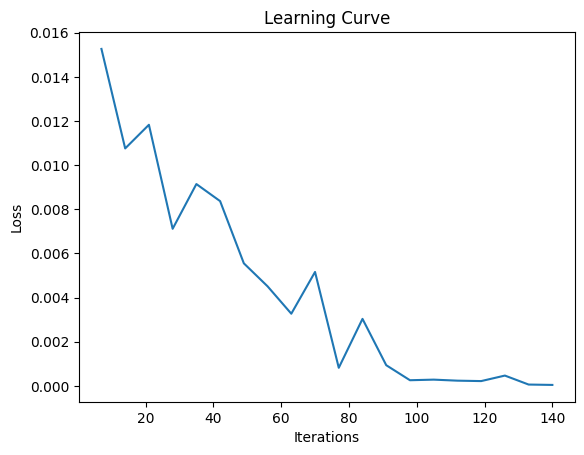

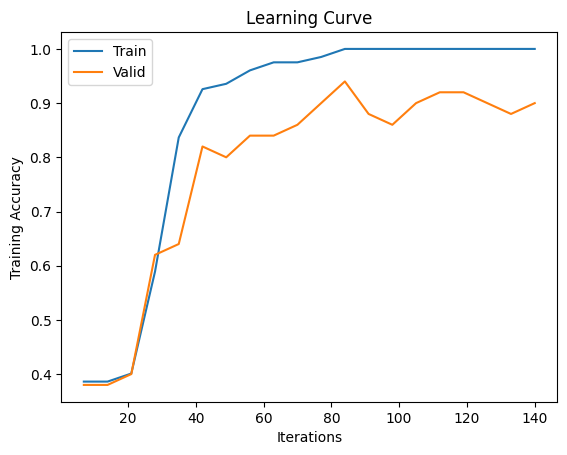

Final Training Accuracy: 1.0


In [95]:
train(VGG19MM, traindata, batch_size=32 ,num_epochs=20, valid_data=testdata)

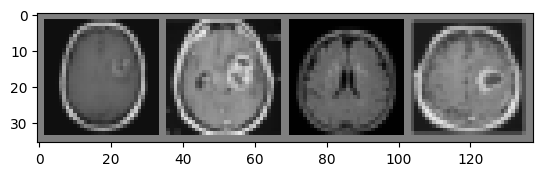

GroundTruth:    yes   yes    no   yes
Predicted:    yes   yes    no   yes
Accuracy of the network on the 50 test images: 94 %


In [96]:
def TestModel(net, testdata):
    # display images from test set
    classes = testdata.classes
    test_loader = torch.utils.data.DataLoader(testdata,
                                              batch_size=4,
                                              shuffle=True)
    dataiter = iter(test_loader)
    images, labels = next(dataiter)


    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


    # object categories predicted by the network
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

    # accuracy on the full test data set
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 50 test images: %d %%' % (
            100 * correct / total))
TestModel(VGG19MM, testdata)

# Running VGG19 mystery model on asl dataset

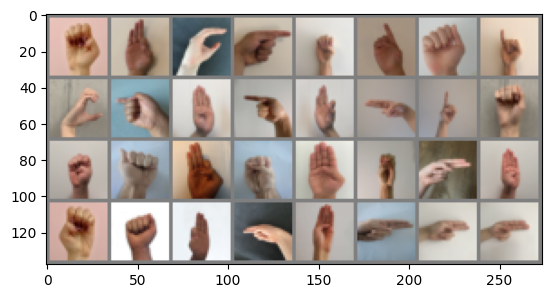

    E     F     C     G


Dataset ImageFolder
    Number of datapoints: 733
    Root location: ./data/asl_data/train/
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [97]:
traindata, testdata, validdata = dataPreparation(path="./data/asl_data/train/", batchsize=32,imagesize=32, pathTest="./data/asl_data/test/", validTest="./data/asl_data/valid/")
traindata

Iter 23; Loss 0.063331; Train Acc 0.164; Val Acc 0.135
Iter 46; Loss 0.049895; Train Acc 0.430; Val Acc 0.329
Iter 69; Loss 0.034791; Train Acc 0.588; Val Acc 0.473
Iter 92; Loss 0.034821; Train Acc 0.693; Val Acc 0.449
Iter 115; Loss 0.024637; Train Acc 0.735; Val Acc 0.517
Iter 138; Loss 0.019324; Train Acc 0.809; Val Acc 0.517
Iter 161; Loss 0.017935; Train Acc 0.809; Val Acc 0.517
Iter 184; Loss 0.011666; Train Acc 0.866; Val Acc 0.560
Iter 207; Loss 0.008936; Train Acc 0.888; Val Acc 0.585
Iter 230; Loss 0.009347; Train Acc 0.915; Val Acc 0.585
Iter 253; Loss 0.012892; Train Acc 0.915; Val Acc 0.623
Iter 276; Loss 0.008597; Train Acc 0.932; Val Acc 0.609
Iter 299; Loss 0.007576; Train Acc 0.963; Val Acc 0.628
Iter 322; Loss 0.007252; Train Acc 0.978; Val Acc 0.604
Iter 345; Loss 0.008837; Train Acc 0.980; Val Acc 0.633
Iter 368; Loss 0.003456; Train Acc 0.978; Val Acc 0.662
Iter 391; Loss 0.002487; Train Acc 0.993; Val Acc 0.633
Iter 414; Loss 0.006585; Train Acc 0.990; Val Acc 0.

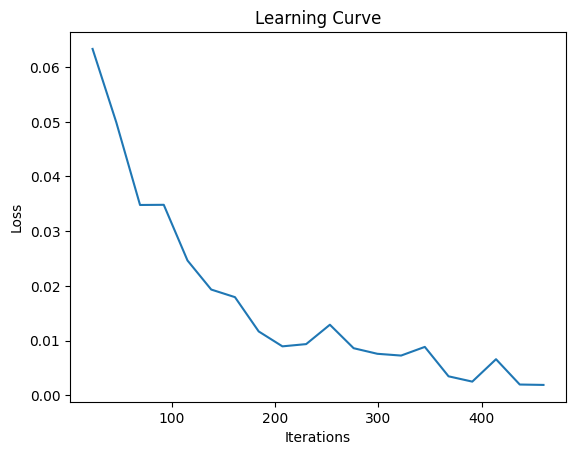

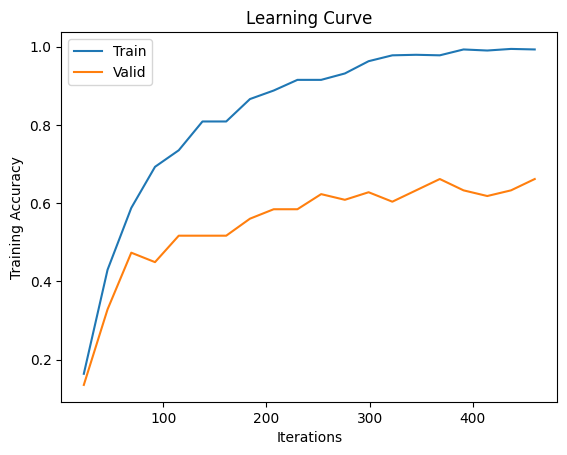

Final Training Accuracy: 0.9931787175989086


In [99]:
VGG19MM = VGG19MM(9)
train(VGG19MM, traindata, batch_size=32, num_epochs=20, valid_data=validdata)

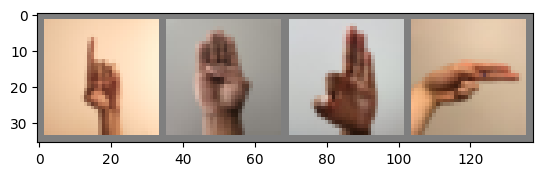

GroundTruth:      D     B     F     H
Predicted:      D     E     D     H
Accuracy of the network on the 50 test images: 68 %


In [100]:
TestModel(VGG19MM, testdata)